try using the EPA's average PM 2.5 concentration for each census tract instead of my DIY method
does it look different? does it correlate with asthma?

THIS WORKS WAY BETTER WHY DOES IT WORK WAY BETTER

what does the EPA know about air quality that I don't (a lot)

In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

from pykrige.ok import OrdinaryKriging

from air_brain.data.get_data import DATA_DIR
from air_brain.util.air import PM25
from air_brain.util.od import od

tract_file = os.path.join(DATA_DIR, "tl_2010_42003_tract10", "tl_2010_42003_tract10.shp")
county_file = os.path.join(DATA_DIR, "county.geojson")
sensor_file = os.path.join(DATA_DIR, "sensor_json.geojson")

In [2]:
tracts = gpd.read_file(tract_file)
tracts.GEOID10 = tracts.GEOID10.astype(int)

In [3]:
asthma_file = os.path.join(DATA_DIR, "asthma.csv")
asthma = pd.read_csv(asthma_file)
# convert all numerators to fractions
for col in ["ED_visits", "ED_hosp", "UC_visits", "Asthma_use"]:
    asthma["{}_frac".format(col)] = asthma[col] / asthma.Total_members

In [4]:
epa_file = os.path.join(DATA_DIR, "epa_ej", "2017_tract.csv")
pm25 = pd.read_csv(epa_file)
pm25

,ID,PM25,O3,traffic,lowincome,poc
0,42003010300,10.597638,37.675955,3609.825745,0.227702,0.324277
1,42003020100,10.580130,37.772252,2505.012911,0.308258,0.233990
2,42003020300,10.595392,37.617420,371.629534,0.133869,0.168675
3,42003030500,10.600417,37.660003,804.087860,0.667865,0.908764
4,42003040200,10.615276,37.567503,1312.219177,0.640420,0.640652
...,...,...,...,...,...,...
397,42003981000,10.611215,37.481443,15.648481,0.000000,0.000000
398,42003981100,10.699466,37.410695,71.138997,0.000000,0.000000
399,42003981200,10.564584,37.857985,0.000000,0.000000,0.000000
400,42003981800,10.653736,37.478700,143.487629,0.847059,0.556270


In [5]:
df = asthma.merge(pm25, left_on="Census_tract", right_on="ID", how="left", validate="1:1")
df.head()

,Census_tract,ED_visits,ED_hosp,UC_visits,Asthma_use,Total_members,ED_visits_frac,ED_hosp_frac,UC_visits_frac,Asthma_use_frac,ID,PM25,O3,traffic,lowincome,poc
0,42003010300,2,0,0,6,83,0.024096,0.000000,0.000000,0.072289,42003010300,10.597638,37.675955,3609.825745,0.227702,0.324277
1,42003020100,32,19,3,223,2114,0.015137,0.008988,0.001419,0.105487,42003020100,10.580130,37.772252,2505.012911,0.308258,0.233990
2,42003020300,0,0,0,2,48,0.000000,0.000000,0.000000,0.041667,42003020300,10.595392,37.617420,371.629534,0.133869,0.168675
3,42003030500,11,3,3,61,422,0.026066,0.007109,0.007109,0.144550,42003030500,10.600417,37.660003,804.087860,0.667865,0.908764
4,42003040200,2,1,1,18,138,0.014493,0.007246,0.007246,0.130435,42003040200,10.615276,37.567503,1312.219177,0.640420,0.640652


<Axes: >

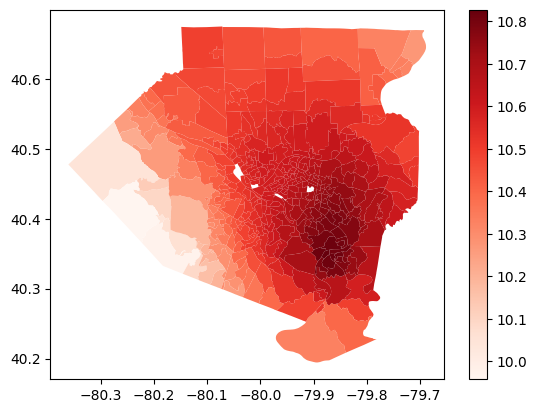

In [6]:
geom_df = tracts.merge(df, left_on="GEOID10", right_on="ID", how="right", validate="1:1")
geom_df.plot(column="PM25", cmap="Reds", legend=True)

<Axes: >

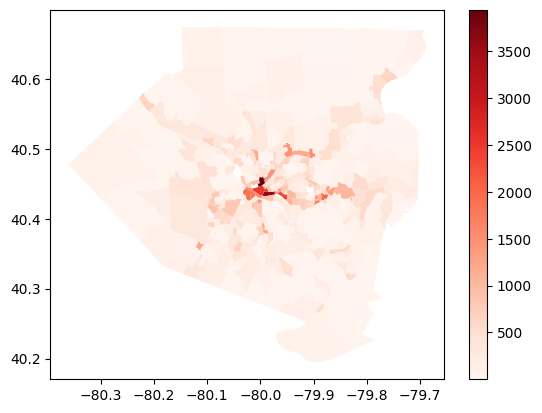

In [7]:
geom_df.plot(column="traffic", cmap="Reds", legend=True)

<Axes: >

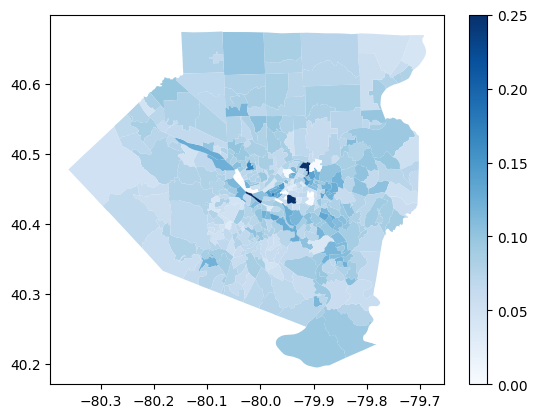

In [8]:
geom_df.plot(column="Asthma_use_frac", cmap="Blues", legend=True, vmin=0, vmax=0.25)

<Axes: xlabel='PM25', ylabel='Asthma_use_frac'>

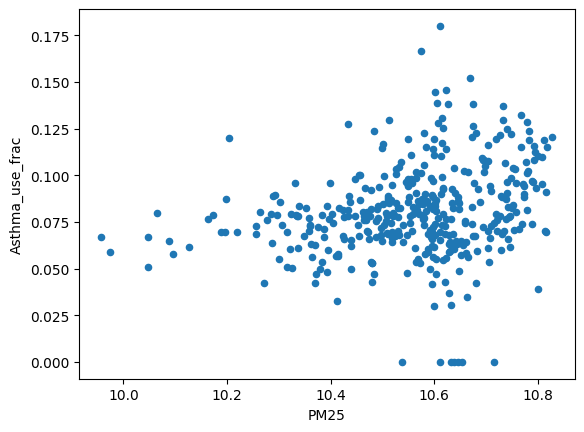

In [10]:
df = df.loc[df.Asthma_use_frac < 0.25]
df.plot(x="PM25", y="Asthma_use_frac", kind="scatter")

<Axes: >

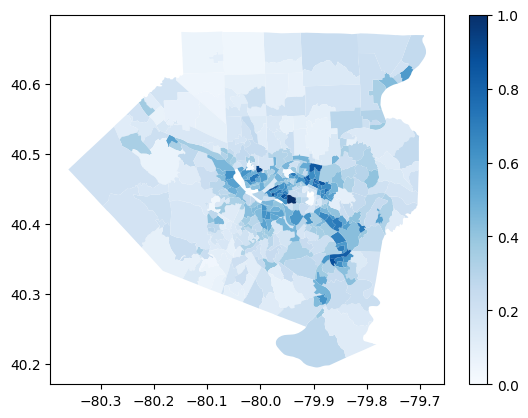

In [9]:
geom_df.plot(column="lowincome", cmap="Blues", legend=True)

<Axes: >

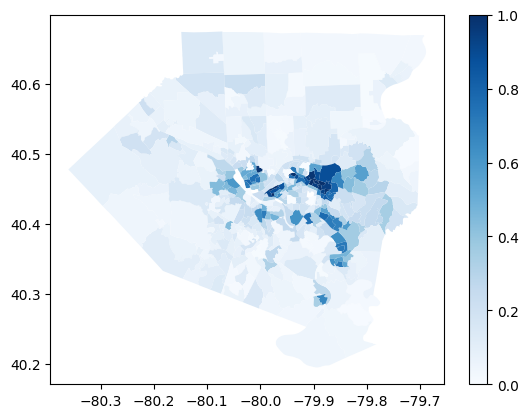

In [12]:
geom_df.plot(column="poc", cmap="Blues", legend=True)

In [11]:
import statsmodels.api as sm
for col in ["ED_visits", "ED_hosp", "UC_visits", "Asthma_use"]:
    mod = sm.OLS(df["{}_frac".format(col)], df[["PM25", "lowincome", "poc"]])
    res = mod.fit()
    print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:         ED_visits_frac   R-squared (uncentered):                   0.719
Model:                            OLS   Adj. R-squared (uncentered):              0.717
Method:                 Least Squares   F-statistic:                              334.4
Date:                Thu, 26 Dec 2024   Prob (F-statistic):                   1.17e-107
Time:                        16:53:02   Log-Likelihood:                          1467.7
No. Observations:                 395   AIC:                                     -2929.
Df Residuals:                     392   BIC:                                     -2917.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------